In [1]:
from oggm import utils
utils.get_rgi_dir(version='62')  # path to the data after download

'/home/dcl/OGGM/rgi/RGIV62'

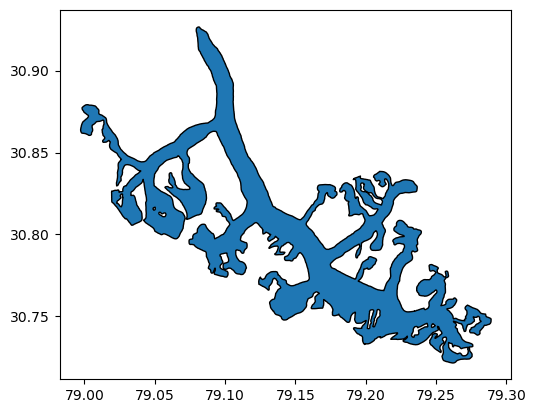

In [3]:
#Read glacier directory from RGI6 
#Here choose Gangotri glacier for example
al = utils.get_rgi_glacier_entities(['RGI60-15.06881'], version='62')
al.plot(edgecolor='k');

In [5]:
#generate OGGM model
from oggm import cfg, workflow, tasks, DEFAULT_BASE_URL
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border'] = 80
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Gangotri-Glacier', reset=True)

# Go - get the pre-processed glacier directories
gdirs = workflow.init_glacier_directories(al, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=5)

2024-08-02 12:08:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-02 12:08:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-02 12:08:05: oggm.cfg: Multiprocessing: using all available processors (N=22)
2024-08-02 12:08:06: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-08-02 12:08:06: oggm.cfg: Multiprocessing switched ON after user settings.
2024-08-02 12:08:07: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-08-02 12:08:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
  0% of 137.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% of 137.9 MiB |#####                 | Elapsed Time: 0:00:15 ETA:   0:00:44
 87% of 137.9 MiB |###################   | Elapsed Time: 0:00:30 ETA:   0:00:04
100% of 137.9 MiB |######################| Elapsed Time: 0:00:33 Time:  0:00:33


In [6]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL
from oggm.shop import gcm_climate

In [16]:
#show the variables in model output
ds

<xarray.Dataset> Size: 8kB
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 656B 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 56B 'RGI60-15.06881'
    hydro_year      (time) int64 656B 2020 2021 2022 2023 ... 2099 2100 2101
    hydro_month     (time) int64 656B 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 656B 2020 2021 2022 2023 ... 2099 2100 2101
    calendar_month  (time) int64 656B 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 656B 1.755e+10 1.745e+10 ... 1.2e+09
    volume_bsl      (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area            (time, rgi_id) float64 656B 1.21e+08 1.21e+08 ... 3.253e+07
    length          (time, rgi_id) float64 656B 2.178e+04 2.178e+04 ... 2.97e+03
    calving         (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    calving_rate    (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    water_level     (rgi_id) float64 8B 0.0
    glen_a          (rgi_id) float64 8B 1.629e-23
    fs              (rgi_id) float64 8B 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-08-02 08:05:07

2024-08-02 12:10:38: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-08-02 12:10:38: oggm.utils: Applying compile_run_output on 1 gdirs.


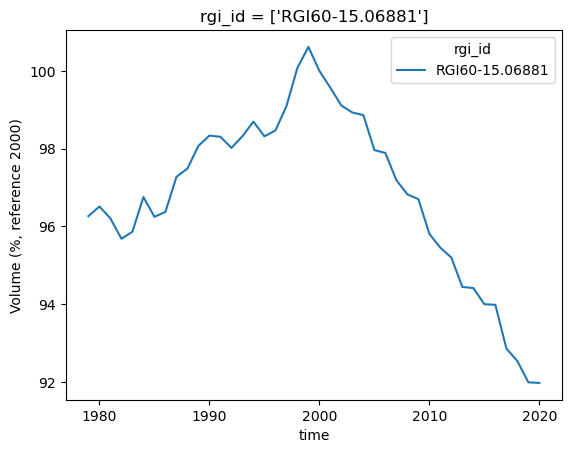

In [7]:
#show volume change for example
ds = utils.compile_run_output(gdirs, input_filesuffix='_spinup_historical')
(ds.volume / ds.volume.sel(time=2000) * 100).plot(hue='rgi_id');
plt.ylabel('Volume (%, reference 2000)');

In [8]:
#  Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)
#  choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2024-08-02 12:11:11: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-02 12:11:12: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-02 12:11:13: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


In [9]:
# run OGGM under various scenarios starting from the end year of the historical spin-up run:
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2024-08-02 12:11:31: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-02 12:11:32: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-02 12:11:32: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


2024-08-02 16:05:07: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-08-02 16:05:07: oggm.utils: Applying compile_run_output on 1 gdirs.


2024-08-02 16:05:07: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-08-02 16:05:07: oggm.utils: Applying compile_run_output on 1 gdirs.
2024-08-02 16:05:07: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-08-02 16:05:07: oggm.utils: Applying compile_run_output on 1 gdirs.


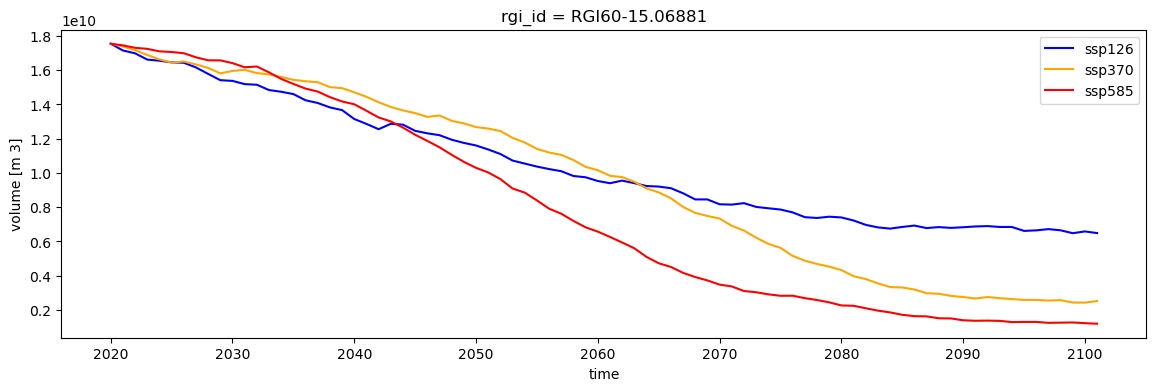

In [15]:
#Plot model output

f, (ax1) = plt.subplots(1, 1, figsize=(14, 4))
# Pick some colors for the lines
color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}
for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    # Compile the output into one file
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    # Plot it
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=ssp, c=color_dict[ssp]);
    # ds.isel(rgi_id=1).volume.plot(ax=ax2, label=ssp, c=color_dict[ssp]);
plt.legend();

In [17]:
ds

<xarray.Dataset> Size: 8kB
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 656B 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 56B 'RGI60-15.06881'
    hydro_year      (time) int64 656B 2020 2021 2022 2023 ... 2099 2100 2101
    hydro_month     (time) int64 656B 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 656B 2020 2021 2022 2023 ... 2099 2100 2101
    calendar_month  (time) int64 656B 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 656B 1.755e+10 1.745e+10 ... 1.2e+09
    volume_bsl      (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area            (time, rgi_id) float64 656B 1.21e+08 1.21e+08 ... 3.253e+07
    length          (time, rgi_id) float64 656B 2.178e+04 2.178e+04 ... 2.97e+03
    calving         (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    calving_rate    (time, rgi_id) float64 656B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    water_level     (rgi_id) float64 8B 0.0
    glen_a          (rgi_id) float64 8B 1.629e-23
    fs              (rgi_id) float64 8B 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-08-02 08:05:07